In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
#UNIFORM DISTR. --> 2 NEURONS
#                       

import torch
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader
import random
from mpl_toolkits.axes_grid1 import AxesGrid

In [3]:
#Architecture parameters and distributions of stimuli
N = 2
K = 10
p_x = torch.distributions.uniform.Uniform(0,15)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]  #creates a 1D tensor of size 1000 whose values are evenly spaced from x_min and x_max



In [4]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
dec = MLPDecoder(N,200)
r = enc.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)


Text(0, 0.5, 'Encoding')

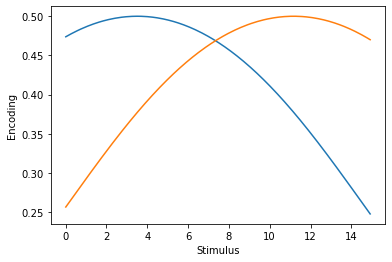

In [5]:
#Initialized encoder before training
plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [6]:
##functions for the losses
q = rate_ising(N)
loss = q(enc,x_fine)
dist = distortion_gaussian(x_fine,enc,dec)


GRADIENT DESCENT ON THE WHOLE SET OF PARAMETERS ( encoder, decoder, h, J)    

In [7]:
#Traning on the entire set of parameters
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(enc.parameters(),q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_)
        dist = distortion_gaussian(x_,enc,dec)
        loss = rate + dist
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())

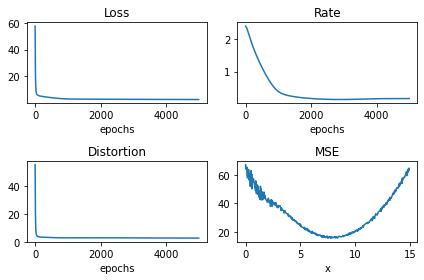

In [8]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

Text(0, 0.5, 'Encoding')

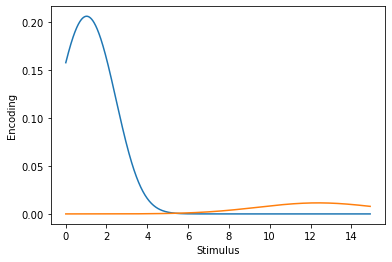

In [9]:
#Tuning curves with learned parameters
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

I want to find the best parameters h and J that minimize the rate considering a fixed encoder whose parameters are kept equal to the initialized ones (first step of EM). 
The parameters being optimized are then the decoder's ones + h and J

In [10]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(q.parameters(), dec.parameters())
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        rate = q(enc,x_)
        dist = distortion_gaussian(x_,enc,dec)
        loss = rate + dist
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())

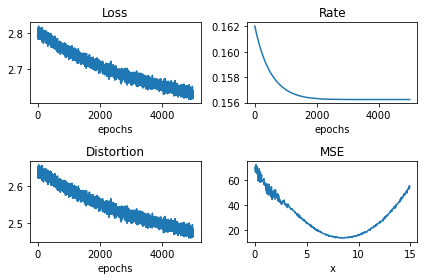

In [11]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()

In [12]:
q.h
q.J


Parameter containing:
tensor([[ 0.0000, -2.2189],
        [-2.2189,  0.0000]], requires_grad=True)

In [13]:
W = np.sqrt(1/N)*torch.randn(N,N)
J0 = W*W.transpose(0,1)
J0.fill_diagonal_(0)

tensor([[0.0000, 0.0485],
        [0.0485, 0.0000]])

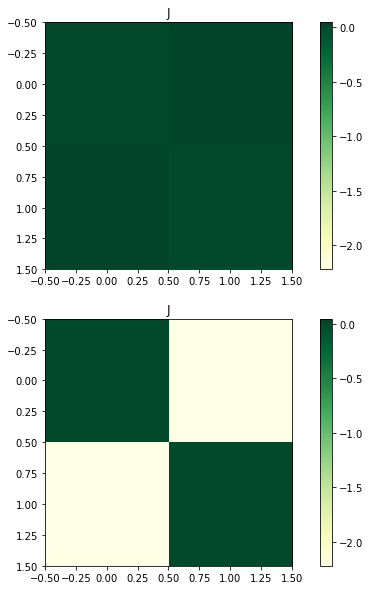

In [14]:
a = (q.J).detach()
show_plots([J0, a])

In [16]:
class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_sigma(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r



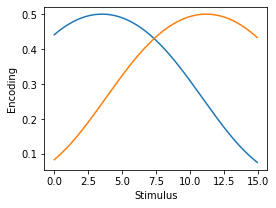

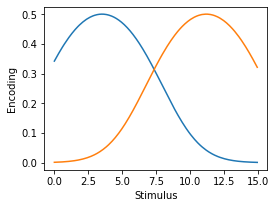

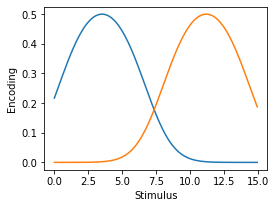

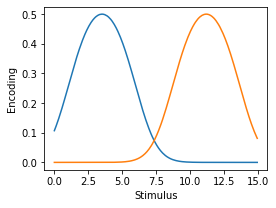

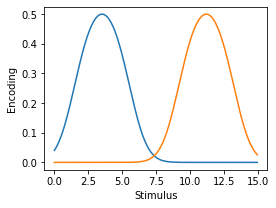

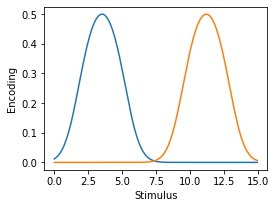

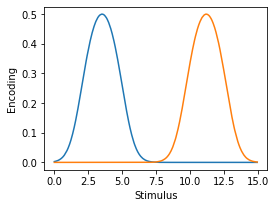

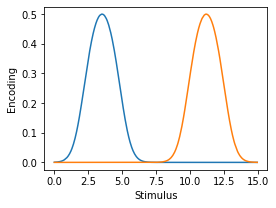

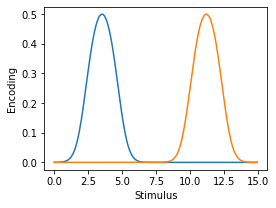

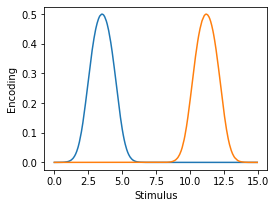

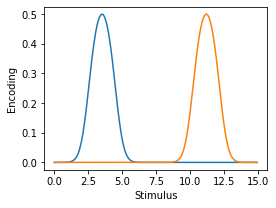

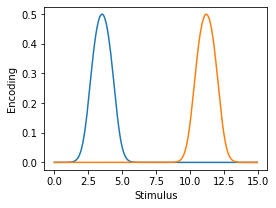

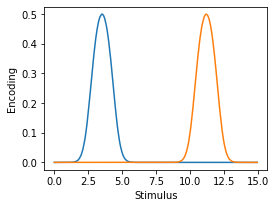

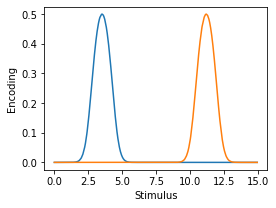

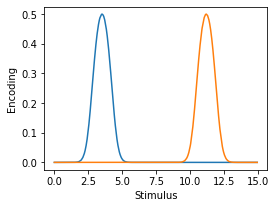

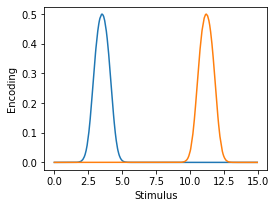

In [17]:
#Visualizing how the tuning curves vary when I vary w
for w in range(3,35,2):
    

    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")

In [18]:
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    qq = rate_ising(N)
    qqq = qq(enc, x_sorted)
    rateVec.append(qqq.item())

sigmas = []
for w in range(3,30,2):
    sigma = (x_max-x_min)/w
    sigmas.append(sigma)


Text(0.5, 1.0, 'Rate as a function of sigma')

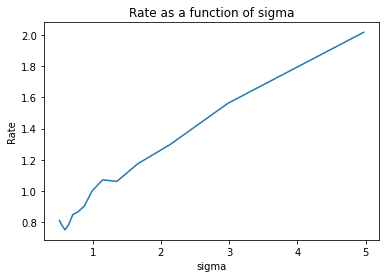

In [19]:
plt.plot(sigmas,rateVec)
plt.xlabel("sigma")
plt.ylabel("Rate")
plt.title("Rate as a function of sigma")

In [20]:
#learning sui parametri del rate
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)

    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           #dist = distortion_gaussian(x_,enc,dec)
           loss = rate
    
           opt.zero_grad()
           loss.backward()
           opt.step()
        
           
    rateVec.append(rate.item())


Text(0.5, 1.0, 'Rate as a function of sigma')

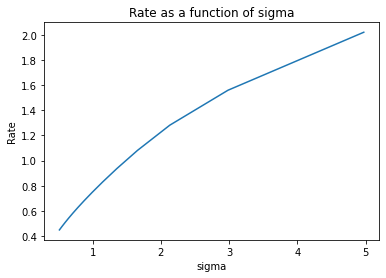

In [21]:
plt.plot(sigmas, rateVec)
plt.xlabel("sigma")
plt.ylabel("Rate")
plt.title("Rate as a function of sigma")

I want to check how J varies when the sigmas are varied. The encoder is fixed, I'm performing gradient descent only on h,J and the decoder parameters

In [22]:
#try: gradient descent only on h and J (rate)
Js_sigma = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q = rate_ising(N)
    rate = q(enc,x_sorted)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters(), dec.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)

    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           dist = distortion_gaussian(x_,enc,dec)
           loss = rate + dist
    
           opt.zero_grad()
           loss.backward()
           opt.step()
        
    J_item = q.J.detach()
    Js_sigma.append(J_item)

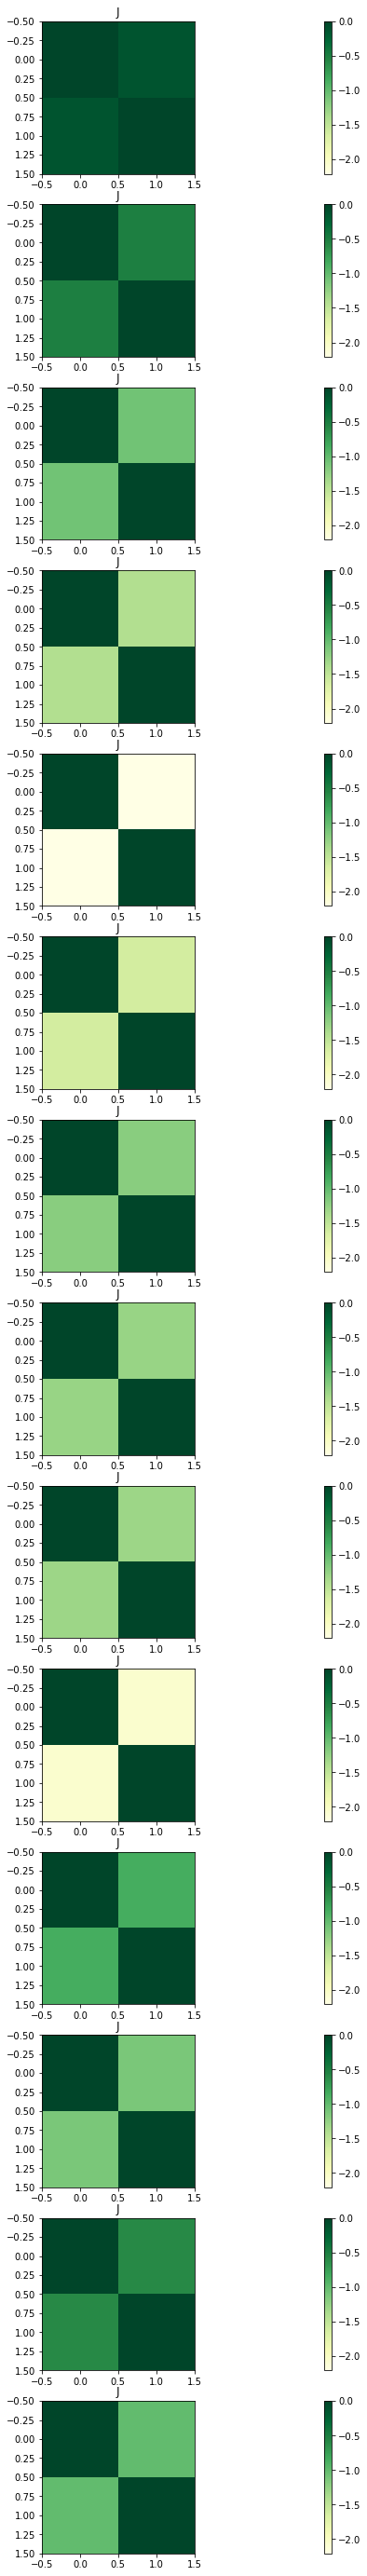

In [24]:
from mpl_toolkits.axes_grid1 import AxesGrid
def show_plots(elements):
    
    combined_data = torch.stack(elements).detach().numpy()
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(50,50))
    for i in range(len(elements)):
        ax = fig.add_subplot(len(elements), 1, i+1)
        #Add the vmin and vmax arguments to set the color scale
        im=ax.imshow(elements[i],cmap=plt.cm.YlGn, vmin = _min, vmax = _max)
        ax.set_title("J")
        fig.colorbar(im, ax=ax)
        

    plt.show()
show_plots(Js_sigma)

I repeat the same analysis I've just performed varying the curves' widths and analyzing the correspective J matrices, but this time varying their centroids.

In [25]:
class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params_mu(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r

#Visualizing how the tuning curves vary when I vary w
for w in range(0,10,1):
    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding")
    print(enc.cs)

In [26]:
Js_mu = []
for w in range(0,10,1):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    q = rate_ising(N)
    rate = q(enc,x_sorted)
    q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
    params = itertools.chain(q.parameters(), dec.parameters())
    lr = 1e-3
    opt = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           rate = q(enc,x_)
           dist = distortion_gaussian(x_,enc,dec)
           loss = rate + dist
           opt.zero_grad()
           loss.backward()
           opt.step()
       
    J_item = q.J.detach()
    Js_mu.append(J_item)

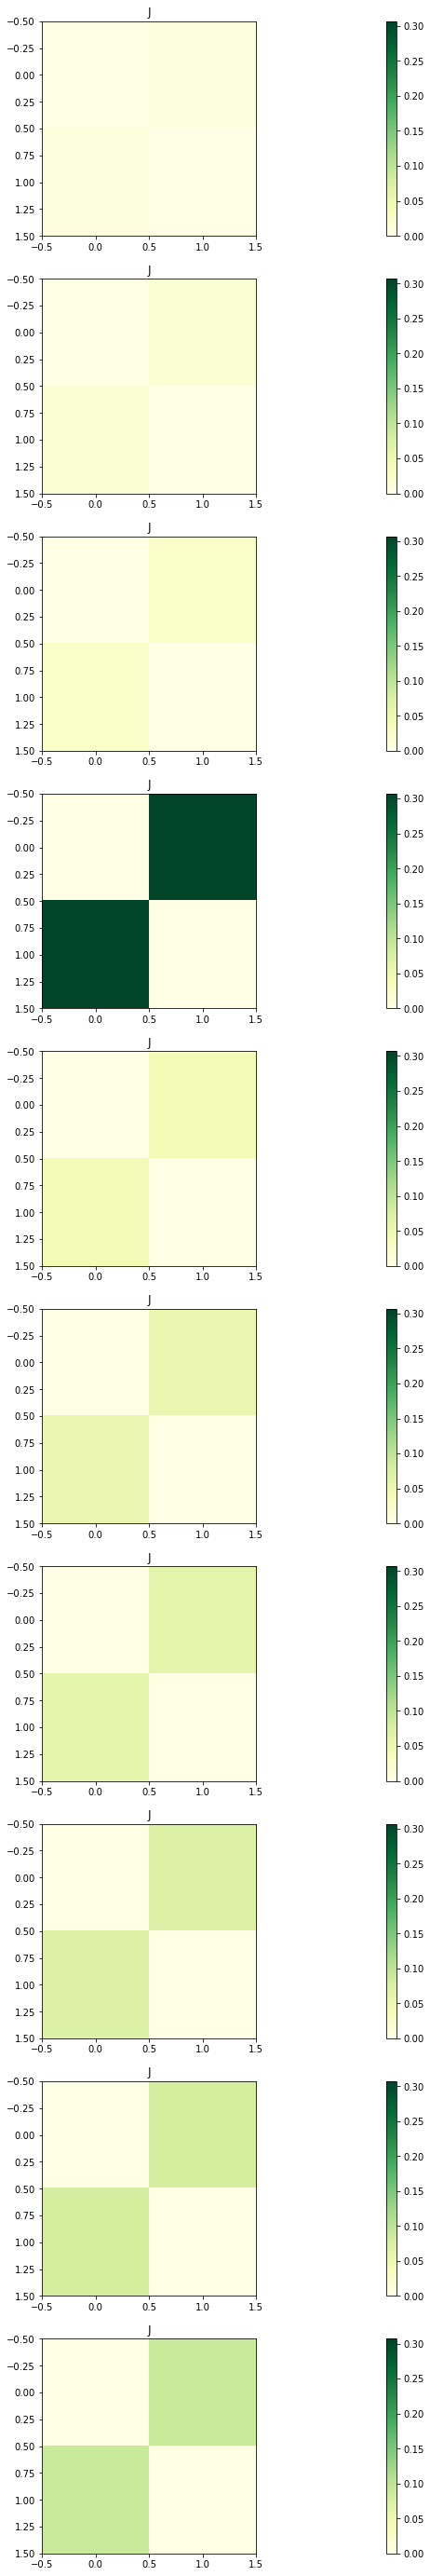

In [27]:
show_plots(Js_mu)